In [1]:
import os
import urllib.request
import zipfile

def download_tiny_imagenet(data_dir='./data'):
    os.makedirs(data_dir, exist_ok=True)
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    zip_path = os.path.join(data_dir, 'tiny-imagenet-200.zip')

    if not os.path.exists(os.path.join(data_dir, 'tiny-imagenet-200')):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        print("Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        os.remove(zip_path)
        print("Done!")
    else:
        print("Tiny ImageNet already downloaded.")

    return os.path.join(data_dir, 'tiny-imagenet-200')


### **Albumentations Transforms**

(https://github.com/albumentations-team/albumentations)

It defines train_tfms using A.Compose to chain together several augmentation techniques from albumentations.

It defines train_tfms using `A.Compose` to chain together several augmentation techniques from albumentations

1. `A.HorizontalFlip`: Randomly flips images horizontally.
2. `A.ShiftScaleRotate`: Applies random affine transformations (shifting, scaling, and rotating).
3. `A.CoarseDropout`: (this is **CutOut**) Randomly drops rectangular regions from the image and fills them with the calculated mean value.
4. `A.Normalize`: Normalizes the pixel values using the pre-computed `MEAN` and `STD`.
5. `ToTensorV2`: Converts the augmented image (which is a NumPy array at this point in the albumentations pipeline) into a PyTorch tensor and moves the channel dimension to the front (C, H, W).

`AlbuTinyImageNet` Dataset Class: It creates a custom Dataset class AlbuCIFAR that wraps the standard tiny imagenet dataset. T**his is necessary because albumentations works with NumPy arrays in HWC (Height, Width, Channel) format, while torchvision datasets return PIL Images (which are converted to tensors in C, H, W format by their default ToTensor)**. The __getitem__ method converts the PIL Image to a NumPy array before applying the albumentations transform.





In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import os

# ImageNet normalization stats (standard for ImageNet-based datasets)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Convert to 0..255 for fill_value
fill_value_255 = tuple(int(m * 255) for m in MEAN)

def get_train_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=15, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
        A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
                        min_holes=1, min_height=int(image_size*0.25), min_width=int(image_size*0.25),
                        fill_value=fill_value_255, p=0.5),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

def get_val_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

class AlbuTinyImageNet(Dataset):
    def __init__(self, root, train=True, transform=None):
        split = 'train' if train else 'val'
        self.ds = datasets.ImageFolder(os.path.join(root, split))
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]  # PIL Image
        img = np.array(img)        # -> HWC uint8 RGB
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        return img, label


In [3]:
def get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2):
    """
    Create train and validation dataloaders for Tiny ImageNet

    Args:
        data_path: Path to tiny-imagenet-200 directory
        batch_size: Batch size for training
        image_size: Target image size (64 for now, 224 for later)
        num_workers: Number of worker processes
    """
    train_tfms = get_train_transforms(image_size)
    val_tfms = get_val_transforms(image_size)

    train_ds = AlbuTinyImageNet(root=data_path, train=True, transform=train_tfms)
    val_ds = AlbuTinyImageNet(root=data_path, train=False, transform=val_tfms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader


In [4]:
import os
import shutil

def reorganize_val_folder(data_path):
    """Reorganize Tiny ImageNet validation folder to work with ImageFolder"""
    val_dir = os.path.join(data_path, 'val')
    img_dir = os.path.join(val_dir, 'images')
    annotations_file = os.path.join(val_dir, 'val_annotations.txt')

    # Read annotations
    with open(annotations_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            img_name = parts[0]
            class_id = parts[1]

            # Create class folder if it doesn't exist
            class_folder = os.path.join(val_dir, class_id)
            os.makedirs(class_folder, exist_ok=True)

            # Move image to class folder
            src = os.path.join(img_dir, img_name)
            dst = os.path.join(class_folder, img_name)
            if os.path.exists(src):
                shutil.move(src, dst)

    # Remove empty images folder
    if os.path.exists(img_dir) and not os.listdir(img_dir):
        os.rmdir(img_dir)

    print("Validation folder reorganized successfully!")

In [5]:
# Download data
data_path = download_tiny_imagenet()

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

Extracting...
Done!


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),


**Quick sanity check**

In [5]:
# Peek a batch and verify normalization stats roughly centered
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "| dtype:", imgs.dtype, "| range ~", (imgs.min().item(), imgs.max().item()))
print("Per-channel mean (batch):", imgs.mean(dim=(0,2,3)))
print("Per-channel std  (batch):", imgs.std(dim=(0,2,3)))

Batch shape: torch.Size([128, 3, 64, 64]) | dtype: torch.float32 | range ~ (-2.1179039478302, 2.6399998664855957)
Per-channel mean (batch): tensor([-0.1620, -0.1637, -0.2082])
Per-channel std  (batch): tensor([1.2394, 1.2241, 1.2341])


**Helper: denormalize + show grid**

In [6]:
# Utils to denormalize and visualize a small grid of images
import math
import torch
import matplotlib.pyplot as plt

# Use MEAN/STD computed earlier (lists) and make tensors for broadcasting
_MEAN = torch.tensor(MEAN).view(1, 3, 1, 1)
_STD  = torch.tensor(STD).view(1, 3, 1, 1)

def denorm(imgs):
    """imgs: tensor [B,C,H,W] normalized with MEAN/STD -> return in [0,1]"""
    x = imgs.clone().cpu()
    x = x * _STD + _MEAN
    return x.clamp(0.0, 1.0)

def show_batch(images, labels, class_names, n=16, cols=8):
    """
    Show n images with titles (class names) in a grid.
    images: [B,C,H,W] tensor (normalized)
    labels: [B] tensor
    """
    n = min(n, images.size(0))
    rows = math.ceil(n / cols)
    imgs = denorm(images[:n])

    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i in range(n):
        img = imgs[i].permute(1, 2, 0).numpy()  # HWC
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(class_names[int(labels[i])], fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


**View a random training batch (with augmentations)**

/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),


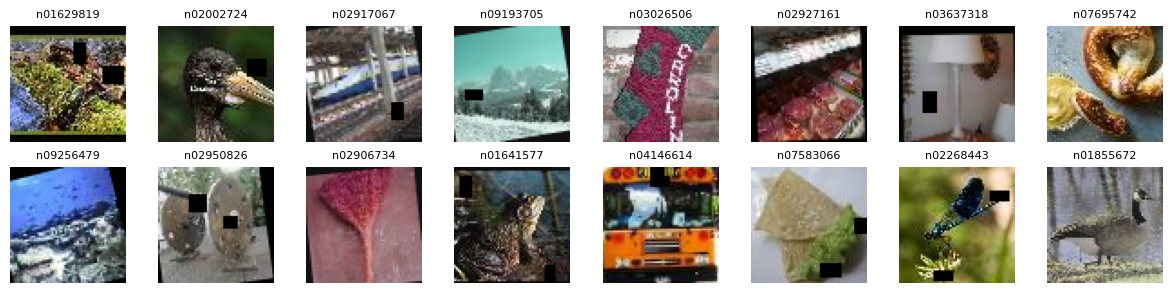

In [7]:
import matplotlib.pyplot as plt

train_ds = AlbuTinyImageNet(root=data_path, train=True, transform=get_train_transforms(64))
class_names = train_ds.ds.classes


def show_batch(images, labels, class_names, n=16, cols=8):
    """Display a batch of images with their labels."""
    n = min(n, len(images))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()  # CHW -> HWC
        img = img * np.array(STD) + np.array(MEAN)  # denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]], fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display batch
train_images, train_labels = next(iter(train_loader))
show_batch(train_images, train_labels, class_names, n=16, cols=8)


**View a random test batch (no augmentations)**

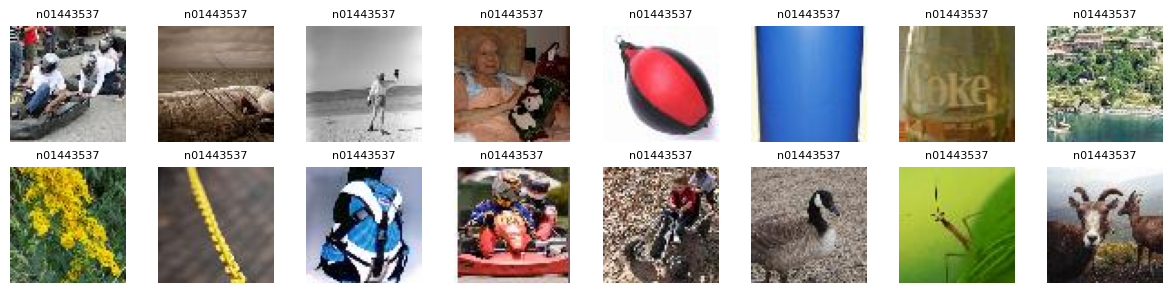

In [11]:
val_images, val_labels = next(iter(val_loader))
show_batch(val_images, val_labels, class_names, n=16, cols=8)

In [13]:
import copy
import torch
import torch.nn.functional as F
from tqdm import tqdm

# keep your history lists (now store epoch-level stats)
train_losses, test_losses = [], []
train_acc,    test_acc    = [], []

class EarlyStopping:
    def __init__(self, patience=6, min_delta=1e-4, restore_best_weights=True, checkpoint_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.checkpoint_path = checkpoint_path
        self.best = float('inf')
        self.wait = 0
        self.best_state = None

    def step(self, val_loss, model):
        improved = (self.best - val_loss) > self.min_delta
        if improved:
            self.best = val_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_state = copy.deepcopy(model.state_dict())
            if self.checkpoint_path:
                torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.wait += 1
        return self.wait >= self.patience

    def load_best(self, model):
        if self.restore_best_weights and self.best_state is not None:
            model.load_state_dict(self.best_state)
        elif self.checkpoint_path:
            model.load_state_dict(torch.load(self.checkpoint_path, map_location="cpu"))

def train(model, device, train_loader, optimizer, scheduler,epoch):
    model.train()
    pbar = tqdm(train_loader, desc=f"Train E{epoch:02d}")
    correct, total = 0, 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target, label_smoothing=0.1)
        loss.backward()
        optimizer.step()
        scheduler.step() # added this step to invoke LR Scheduler

        # stats
        running_loss += loss.item() * data.size(0)
        pred = y_pred.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += data.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc  = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    return epoch_loss, epoch_acc

# mix precision training loop

from torch.cuda.amp import autocast, GradScaler

def train(model, device, train_loader, optimizer, scheduler, epoch, scaler):
    model.train()
    pbar = tqdm(train_loader, desc=f"Train E{epoch:02d}")
    correct, total = 0, 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            y_pred = model(data)
            loss = F.cross_entropy(y_pred, target, label_smoothing=0.1)

        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        # stats
        running_loss += loss.item() * data.size(0)
        pred = y_pred.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += data.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc  = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    return epoch_loss, epoch_acc


def test(model, device, test_loader, epoch=None):
    model.eval()
    test_loss_sum, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum', label_smoothing=0.1)  # sum over batch
            test_loss_sum += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += data.size(0)

    avg_loss = test_loss_sum / total
    acc = 100.0 * correct / total
    test_losses.append(avg_loss)
    test_acc.append(acc)

    if epoch is not None:
        print(f"\nVal E{epoch:02d}: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")
    else:
        print(f"\nVal: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")

    return avg_loss, acc


### ResNet50 without ReLu (Pre-activation ResNet)

**Load Model** - ResNet50 (without activation in skip connection)
```

BN → ReLU → Conv1x1 → BN → ReLU → Conv3x3 → BN → ReLU → Conv1x1
                                                              ↓
identity --------------------------------------------------------→ ADD (no ReLU here!)
```


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """Pre-activation ResNet Basic Block"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = F.relu(out, inplace=True)
        out = self.conv1(out)

        out = self.bn2(out)
        out = F.relu(out, inplace=True)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # No ReLU after addition!

        return out

class BottleneckBlock(nn.Module):
    """Pre-activation ResNet Bottleneck Block"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = F.relu(out, inplace=True)
        out = self.conv1(out)

        out = self.bn2(out)
        out = F.relu(out, inplace=True)
        out = self.conv2(out)

        out = self.bn3(out)
        out = F.relu(out, inplace=True)
        out = self.conv3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # No ReLU after addition!

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.in_channels = 64

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Factory functions
def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def resnet50(num_classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

### ResNet50 with ReLu

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """Original ResNet Basic Block"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)  # ReLU after addition!

        return out


class BottleneckBlock(nn.Module):
    """Original ResNet Bottleneck Block"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample

    def forward(self, x):
      identity = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = F.relu(out, inplace=True)

      out = self.conv2(out)  # <- Fixed: was self.conv2(x)
      out = self.bn2(out)
      out = F.relu(out, inplace=True)

      out = self.conv3(out)
      out = self.bn3(out)

      if self.downsample is not None:
          identity = self.downsample(x)

      out += identity
      out = F.relu(out, inplace=True)

      return out



class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.in_channels = 64

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Factory functions

def resnet50_with_relu(num_classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

### ResNet with ReLu with conv instead of fc

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """Original ResNet Basic Block"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)  # ReLU after addition!

        return out


class BottleneckBlock(nn.Module):
    """Original ResNet Bottleneck Block"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample

    def forward(self, x):
      identity = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = F.relu(out, inplace=True)

      out = self.conv2(out)  # <- Fixed: was self.conv2(x)
      out = self.bn2(out)
      out = F.relu(out, inplace=True)

      out = self.conv3(out)
      out = self.bn3(out)

      if self.downsample is not None:
          identity = self.downsample(x)

      out += identity
      out = F.relu(out, inplace=True)

      return out



class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.in_channels = 64

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.fc = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = torch.flatten(x, 1)

        return x

# Factory functions

def resnet50_with_relu_conv(num_classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

### model & model summary

In [8]:
# model = resnet50_with_relu(num_classes=200)
# model = resnet50(num_classes=200)
model = resnet50_with_relu_conv(num_classes=200)

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]           4,096
       BatchNorm2d-5             [-1, 64, 8, 8]             128
            Conv2d-6             [-1, 64, 8, 8]          36,864
       BatchNorm2d-7             [-1, 64, 8, 8]             128
            Conv2d-8            [-1, 256, 8, 8]          16,384
       BatchNorm2d-9            [-1, 256, 8, 8]             512
           Conv2d-10            [-1, 256, 8, 8]          16,384
      BatchNorm2d-11            [-1, 256, 8, 8]             512
  BottleneckBlock-12            [-1, 256, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          16,384
      BatchNorm2d-14             [

### Finding the learning rate for OneCylePolicy LR Scheduler

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.17E-04


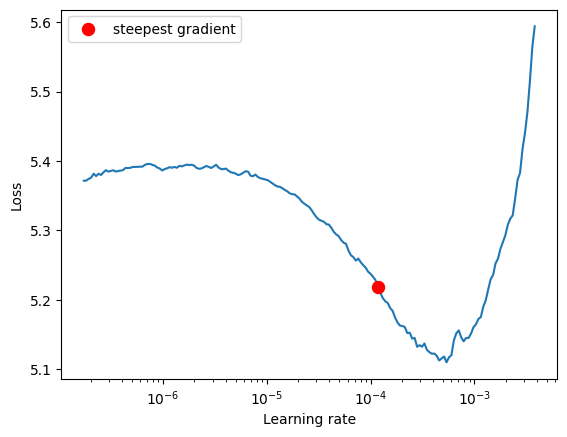

In [16]:
# Install if needed
!pip install torch-lr-finder

import torch.optim as optim
from torch_lr_finder import LRFinder

# Create fresh model and optimizer
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Run LR finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=0.005, num_iter=200)
lr_finder.plot()  # Shows the loss vs learning rate
lr_finder.reset()  # Reset model and optimizer

### **run it!! - reorganize validation files (important to run once)**

In [10]:
# Run it
reorganize_val_folder(data_path)

Validation folder reorganized successfully!


### 1 base configuration model
**Observation**: stagnates to ~40% accuracy - 28 - 30 epoch.

- basic transforms
- resnet50 with relu removed
- batch size 128
- image size 64
- lr rate based on lr_finder
- max lr - 10x of lr rate

In [22]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

early_stop = EarlyStopping(
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_resnet50_tinyimagenet.pt"  # Updated name
)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)  # Use val_loader, not test_loader

    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

early_stop.load_best(model)
print("Training complete! Best val loss:", f"{early_stop.best:.4f}")

Device: cuda


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 782/782 [02:04<00:00,  6.28it/s, acc=7.66%, loss=4.1330]



Val E01: loss=4.0172, acc=1400/10000 (14.00%)



Train E02: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s, acc=16.08%, loss=3.8708]



Val E02: loss=3.5917, acc=2019/10000 (20.19%)



Train E03: 100%|██████████| 782/782 [02:03<00:00,  6.35it/s, acc=21.13%, loss=3.6777]



Val E03: loss=3.4187, acc=2340/10000 (23.40%)



Train E04: 100%|██████████| 782/782 [02:03<00:00,  6.33it/s, acc=24.52%, loss=3.1515]



Val E04: loss=3.3053, acc=2513/10000 (25.13%)



Train E05: 100%|██████████| 782/782 [02:03<00:00,  6.32it/s, acc=27.24%, loss=3.9371]



Val E05: loss=3.1704, acc=2752/10000 (27.52%)



Train E06: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=29.69%, loss=3.4770]



Val E06: loss=3.1186, acc=2918/10000 (29.18%)



Train E07: 100%|██████████| 782/782 [02:03<00:00,  6.32it/s, acc=31.46%, loss=2.5664]



Val E07: loss=3.0726, acc=3045/10000 (30.45%)



Train E08: 100%|██████████| 782/782 [02:04<00:00,  6.28it/s, acc=33.57%, loss=2.9455]



Val E08: loss=2.9920, acc=3155/10000 (31.55%)



Train E09: 100%|██████████| 782/782 [02:04<00:00,  6.27it/s, acc=34.91%, loss=3.2998]



Val E09: loss=3.0068, acc=3184/10000 (31.84%)



Train E10: 100%|██████████| 782/782 [02:04<00:00,  6.26it/s, acc=36.31%, loss=3.2670]



Val E10: loss=3.0248, acc=3241/10000 (32.41%)



Train E11: 100%|██████████| 782/782 [02:04<00:00,  6.30it/s, acc=37.68%, loss=2.8457]



Val E11: loss=2.9505, acc=3297/10000 (32.97%)



Train E12: 100%|██████████| 782/782 [02:03<00:00,  6.33it/s, acc=38.96%, loss=2.8970]



Val E12: loss=2.8766, acc=3411/10000 (34.11%)



Train E13: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=40.10%, loss=2.7961]



Val E13: loss=2.9355, acc=3451/10000 (34.51%)



Train E14: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=41.74%, loss=2.3866]



Val E14: loss=2.8979, acc=3521/10000 (35.21%)



Train E15: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=43.03%, loss=2.3763]



Val E15: loss=2.7865, acc=3734/10000 (37.34%)



Train E16: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=44.83%, loss=2.1695]



Val E16: loss=2.8428, acc=3717/10000 (37.17%)



Train E17: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=46.36%, loss=2.2395]



Val E17: loss=3.0060, acc=3510/10000 (35.10%)



Train E18: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=48.27%, loss=2.4555]



Val E18: loss=2.9163, acc=3778/10000 (37.78%)



Train E19: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=50.37%, loss=2.4671]



Val E19: loss=2.8130, acc=3876/10000 (38.76%)



Train E20: 100%|██████████| 782/782 [02:03<00:00,  6.35it/s, acc=52.21%, loss=1.9083]



Val E20: loss=2.7825, acc=3919/10000 (39.19%)



Train E21: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=54.30%, loss=2.5799]



Val E21: loss=2.8271, acc=3994/10000 (39.94%)



Train E22: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=56.26%, loss=1.4795]



Val E22: loss=2.9964, acc=3865/10000 (38.65%)



Train E23: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=58.51%, loss=1.6356]



Val E23: loss=3.0609, acc=3892/10000 (38.92%)



Train E24: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=60.59%, loss=1.4701]



Val E24: loss=3.0410, acc=4016/10000 (40.16%)



Train E25: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=62.40%, loss=1.7213]



Val E25: loss=3.1806, acc=3899/10000 (38.99%)



Train E26: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=65.02%, loss=1.8721]



Val E26: loss=3.1947, acc=4002/10000 (40.02%)



Train E27: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=66.85%, loss=1.3381]



Val E27: loss=3.2658, acc=4081/10000 (40.81%)



Train E28: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s, acc=68.86%, loss=1.6361]



Val E28: loss=3.3818, acc=3953/10000 (39.53%)



Train E29:  38%|███▊      | 299/782 [00:47<01:16,  6.34it/s, acc=73.31%, loss=1.2997]


KeyboardInterrupt: 

In [15]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

early_stop = EarlyStopping(
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_resnet50_tinyimagenet.pt"  # Updated name
)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)  # Use val_loader, not test_loader

    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

early_stop.load_best(model)
print("Training complete! Best val loss:", f"{early_stop.best:.4f}")

Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=7.89%, loss=4.6156]



Val E01: loss=4.2826, acc=1381/10000 (13.81%)



Train E02: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=16.20%, loss=4.3858]



Val E02: loss=3.9630, acc=2002/10000 (20.02%)



Train E03: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=21.15%, loss=3.6611]



Val E03: loss=3.7411, acc=2495/10000 (24.95%)



Train E04: 100%|██████████| 782/782 [02:00<00:00,  6.47it/s, acc=24.98%, loss=3.6257]



Val E04: loss=3.6826, acc=2555/10000 (25.55%)



Train E05: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=27.45%, loss=3.6618]



Val E05: loss=3.6305, acc=2694/10000 (26.94%)



Train E06: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=29.83%, loss=3.7227]



Val E06: loss=3.5292, acc=2914/10000 (29.14%)



Train E07: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=32.21%, loss=3.3645]



Val E07: loss=3.4784, acc=3077/10000 (30.77%)



Train E08: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s, acc=33.82%, loss=3.8517]



Val E08: loss=3.4684, acc=3168/10000 (31.68%)



Train E09: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=35.48%, loss=3.1337]



Val E09: loss=3.4720, acc=3223/10000 (32.23%)



Train E10: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=36.85%, loss=3.5987]



Val E10: loss=3.4443, acc=3197/10000 (31.97%)



Train E11: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=38.17%, loss=2.9429]



Val E11: loss=3.3513, acc=3360/10000 (33.60%)



Train E12: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=39.60%, loss=3.5630]



Val E12: loss=3.3279, acc=3434/10000 (34.34%)



Train E13: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=41.08%, loss=3.0604]



Val E13: loss=3.3061, acc=3492/10000 (34.92%)



Train E14: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=42.15%, loss=3.3223]



Val E14: loss=3.3385, acc=3570/10000 (35.70%)



Train E15: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s, acc=44.03%, loss=2.7702]



Val E15: loss=3.2756, acc=3647/10000 (36.47%)



Train E16: 100%|██████████| 782/782 [02:00<00:00,  6.47it/s, acc=45.57%, loss=2.5937]



Val E16: loss=3.2784, acc=3733/10000 (37.33%)



Train E17: 100%|██████████| 782/782 [02:00<00:00,  6.48it/s, acc=47.58%, loss=3.0897]



Val E17: loss=3.2250, acc=3849/10000 (38.49%)



Train E18: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s, acc=49.64%, loss=3.3782]



Val E18: loss=3.2091, acc=3878/10000 (38.78%)



Train E19: 100%|██████████| 782/782 [02:00<00:00,  6.47it/s, acc=51.46%, loss=2.4070]



Val E19: loss=3.2315, acc=3854/10000 (38.54%)



Train E20: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s, acc=53.69%, loss=2.4577]



Val E20: loss=3.2104, acc=3962/10000 (39.62%)



Train E21: 100%|██████████| 782/782 [02:00<00:00,  6.47it/s, acc=55.71%, loss=2.2208]



Val E21: loss=3.2147, acc=4004/10000 (40.04%)



Train E22: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=58.04%, loss=2.3285]



Val E22: loss=3.2509, acc=4033/10000 (40.33%)



Train E23: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s, acc=60.27%, loss=2.7211]



Val E23: loss=3.2517, acc=4039/10000 (40.39%)



Train E24: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=62.30%, loss=2.6071]



Val E24: loss=3.2156, acc=4109/10000 (41.09%)



Train E25: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=64.64%, loss=2.6275]



Val E25: loss=3.3643, acc=3908/10000 (39.08%)



Train E26: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=67.21%, loss=2.5353]



Val E26: loss=3.3894, acc=3946/10000 (39.46%)



Train E27: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=69.38%, loss=2.5346]



Val E27: loss=3.3465, acc=4097/10000 (40.97%)



Train E28: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=71.84%, loss=2.4982]



Val E28: loss=3.3638, acc=4023/10000 (40.23%)



Train E29: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=74.03%, loss=2.1036]



Val E29: loss=3.4064, acc=4021/10000 (40.21%)



Train E30: 100%|██████████| 782/782 [02:00<00:00,  6.47it/s, acc=76.01%, loss=2.1890]



Val E30: loss=3.4082, acc=4023/10000 (40.23%)



Train E31: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s, acc=78.30%, loss=2.1898]



Val E31: loss=3.3877, acc=4128/10000 (41.28%)



Train E32: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=80.24%, loss=1.9277]



Val E32: loss=3.4008, acc=4087/10000 (40.87%)



Train E33: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s, acc=82.25%, loss=1.6579]



Val E33: loss=3.4147, acc=4055/10000 (40.55%)

Early stopping at epoch 33. Best val loss: 3.2091
Training complete! Best val loss: 3.2091


### 2 base configuration + increased batch size
**Observation:** - model stagnates to ~39% accuracy - 28 - 30 epoch.

- basic transforms
- resnet50 with relu removed
- batch size **256**
- image size 64
- lr rate based on lr_finder
- max lr - 10x of lr rate

In [24]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=256, image_size=64, num_workers=2)

model = resnet50(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

early_stop = EarlyStopping(
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_resnet50_tinyimagenet.pt"  # Updated name
)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)  # Use val_loader, not test_loader

    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

early_stop.load_best(model)
print("Training complete! Best val loss:", f"{early_stop.best:.4f}")

Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=6.78%, loss=4.2915]



Val E01: loss=4.1776, acc=1241/10000 (12.41%)



Train E02: 100%|██████████| 391/391 [01:55<00:00,  3.39it/s, acc=14.59%, loss=3.8788]



Val E02: loss=3.7337, acc=1846/10000 (18.46%)



Train E03: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=19.76%, loss=3.4831]



Val E03: loss=3.5005, acc=2194/10000 (21.94%)



Train E04: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=23.30%, loss=3.2662]



Val E04: loss=3.3350, acc=2490/10000 (24.90%)



Train E05: 100%|██████████| 391/391 [01:54<00:00,  3.40it/s, acc=26.23%, loss=3.0115]



Val E05: loss=3.2844, acc=2565/10000 (25.65%)



Train E06: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=28.88%, loss=3.0234]



Val E06: loss=3.1458, acc=2817/10000 (28.17%)



Train E07: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=30.88%, loss=3.1124]



Val E07: loss=3.1477, acc=2836/10000 (28.36%)



Train E08: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=32.99%, loss=2.8133]



Val E08: loss=3.0487, acc=2995/10000 (29.95%)



Train E09: 100%|██████████| 391/391 [01:54<00:00,  3.40it/s, acc=34.84%, loss=2.8436]



Val E09: loss=3.0337, acc=3114/10000 (31.14%)



Train E10: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=36.80%, loss=3.0514]



Val E10: loss=3.0271, acc=3165/10000 (31.65%)



Train E11: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=38.30%, loss=2.6491]



Val E11: loss=2.9479, acc=3299/10000 (32.99%)



Train E12: 100%|██████████| 391/391 [01:55<00:00,  3.40it/s, acc=39.60%, loss=2.6854]



Val E12: loss=2.9645, acc=3336/10000 (33.36%)



Train E13: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=41.17%, loss=2.3279]



Val E13: loss=3.0180, acc=3292/10000 (32.92%)



Train E14: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=42.80%, loss=2.2928]



Val E14: loss=2.9327, acc=3473/10000 (34.73%)



Train E15: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=44.35%, loss=2.4342]



Val E15: loss=3.0429, acc=3349/10000 (33.49%)



Train E16: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=45.87%, loss=2.1716]



Val E16: loss=2.9200, acc=3599/10000 (35.99%)



Train E17: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=47.36%, loss=2.0362]



Val E17: loss=3.0170, acc=3554/10000 (35.54%)



Train E18: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=48.76%, loss=2.1127]



Val E18: loss=2.9195, acc=3642/10000 (36.42%)



Train E19: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=50.86%, loss=2.3157]



Val E19: loss=2.9323, acc=3705/10000 (37.05%)



Train E20: 100%|██████████| 391/391 [01:54<00:00,  3.43it/s, acc=52.87%, loss=1.8948]



Val E20: loss=3.1266, acc=3732/10000 (37.32%)



Train E21: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=54.45%, loss=2.0697]



Val E21: loss=2.9403, acc=3847/10000 (38.47%)



Train E22: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=56.99%, loss=1.6770]



Val E22: loss=3.0053, acc=3748/10000 (37.48%)



Train E23: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=58.90%, loss=1.7946]



Val E23: loss=3.1687, acc=3774/10000 (37.74%)



Train E24: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=61.48%, loss=1.7044]



Val E24: loss=3.2337, acc=3676/10000 (36.76%)



Train E25: 100%|██████████| 391/391 [01:55<00:00,  3.40it/s, acc=63.37%, loss=1.5385]



Val E25: loss=3.3037, acc=3739/10000 (37.39%)



Train E26: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=66.04%, loss=1.4324]



Val E26: loss=3.4543, acc=3825/10000 (38.25%)



Train E27: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=68.05%, loss=1.2913]



Val E27: loss=3.3277, acc=3894/10000 (38.94%)



Train E28: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=70.51%, loss=1.1881]



Val E28: loss=3.3493, acc=3950/10000 (39.50%)



Train E29: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=72.31%, loss=1.3656]



Val E29: loss=3.5086, acc=3883/10000 (38.83%)



Train E30: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=74.10%, loss=0.8964]



Val E30: loss=3.6850, acc=3833/10000 (38.33%)



Train E31: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=76.10%, loss=1.2333]



Val E31: loss=3.7668, acc=3984/10000 (39.84%)



Train E32: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=78.03%, loss=1.2312]



Val E32: loss=3.8321, acc=3980/10000 (39.80%)



Train E33: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=79.44%, loss=0.6905]



Val E33: loss=3.8745, acc=3909/10000 (39.09%)

Early stopping at epoch 33. Best val loss: 2.9195
Training complete! Best val loss: 2.9195


### 3 base configuration + increased batch size + increase max_lr
**Observation**: model increase accuracy earlier but then stagnates - 37%

- basic transforms
- resnet50 with relu removed
- batch size **256**
- image size 64
- lr rate based on lr_finder
- max lr - 50x of lr rate - 5e-3

In [26]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=256, image_size=64, num_workers=2)

model = resnet50(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-3,  # Increased from 1.17e-3
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

early_stop = EarlyStopping(
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_resnet50_tinyimagenet.pt"  # Updated name
)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)  # Use val_loader, not test_loader

    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

early_stop.load_best(model)
print("Training complete! Best val loss:", f"{early_stop.best:.4f}")

Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 391/391 [01:56<00:00,  3.34it/s, acc=10.55%, loss=3.7343]



Val E01: loss=3.7580, acc=1819/10000 (18.19%)



Train E02: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=19.59%, loss=3.4714]



Val E02: loss=3.4506, acc=2286/10000 (22.86%)



Train E03: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=24.30%, loss=3.3514]



Val E03: loss=3.2309, acc=2599/10000 (25.99%)



Train E04: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=27.61%, loss=2.9005]



Val E04: loss=3.1203, acc=2878/10000 (28.78%)



Train E05: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=30.25%, loss=3.0567]



Val E05: loss=3.0701, acc=2996/10000 (29.96%)



Train E06: 100%|██████████| 391/391 [01:55<00:00,  3.40it/s, acc=32.30%, loss=3.0149]



Val E06: loss=3.0374, acc=3090/10000 (30.90%)



Train E07: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=33.96%, loss=2.8719]



Val E07: loss=2.9635, acc=3200/10000 (32.00%)



Train E08: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=35.60%, loss=2.7643]



Val E08: loss=2.7833, acc=3609/10000 (36.09%)



Train E09: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=37.25%, loss=2.4308]



Val E09: loss=2.9082, acc=3386/10000 (33.86%)



Train E10: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=38.95%, loss=2.4611]



Val E10: loss=2.9634, acc=3272/10000 (32.72%)



Train E11: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=40.31%, loss=2.3995]



Val E11: loss=2.8849, acc=3445/10000 (34.45%)



Train E12: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=42.05%, loss=2.5187]



Val E12: loss=2.7382, acc=3661/10000 (36.61%)



Train E13: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=43.56%, loss=2.3838]



Val E13: loss=2.7459, acc=3699/10000 (36.99%)



Train E14: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=45.13%, loss=2.1357]



Val E14: loss=2.7463, acc=3735/10000 (37.35%)



Train E15: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s, acc=46.25%, loss=2.3916]



Val E15: loss=2.6676, acc=3875/10000 (38.75%)



Train E16: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=47.66%, loss=1.9867]



Val E16: loss=2.7303, acc=3813/10000 (38.13%)



Train E17: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=48.97%, loss=2.1777]



Val E17: loss=2.7494, acc=3882/10000 (38.82%)



Train E18: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s, acc=50.33%, loss=2.0012]



Val E18: loss=2.7017, acc=3981/10000 (39.81%)



Train E19: 100%|██████████| 391/391 [01:55<00:00,  3.39it/s, acc=51.59%, loss=1.8732]



Val E19: loss=2.8090, acc=3875/10000 (38.75%)



Train E20: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s, acc=52.58%, loss=2.0819]



Val E20: loss=2.9027, acc=3775/10000 (37.75%)



Train E21: 100%|██████████| 391/391 [01:55<00:00,  3.38it/s, acc=53.69%, loss=1.9002]



Val E21: loss=2.9480, acc=3752/10000 (37.52%)



Train E22: 100%|██████████| 391/391 [01:55<00:00,  3.40it/s, acc=55.01%, loss=1.8025]



Val E22: loss=3.0604, acc=3700/10000 (37.00%)



Train E23:  56%|█████▌    | 218/391 [01:05<00:52,  3.31it/s, acc=57.86%, loss=1.9213]


KeyboardInterrupt: 

### 4 Image size increase to 224
**Observation**: too slow execution single epoch takes 16-18 mins


In [10]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=224, num_workers=2)

model = resnet50(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-3,  # Increased from 1.17e-3
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

early_stop = EarlyStopping(
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_resnet50_tinyimagenet.pt"  # Updated name
)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)  # Use val_loader, not test_loader

    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

early_stop.load_best(model)
print("Training complete! Best val loss:", f"{early_stop.best:.4f}")

Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 782/782 [16:40<00:00,  1.28s/it, acc=11.31%, loss=3.5294]



Val E01: loss=3.7810, acc=1643/10000 (16.43%)



Train E02:  12%|█▏        | 91/782 [01:58<15:00,  1.30s/it, acc=18.35%, loss=3.6440]


KeyboardInterrupt: 

### 5 resnet50_with_relu (new lr)
**Observation**: the training convergence with new lr found is much slower than old lr found for resnet50 without relu

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.91E-05


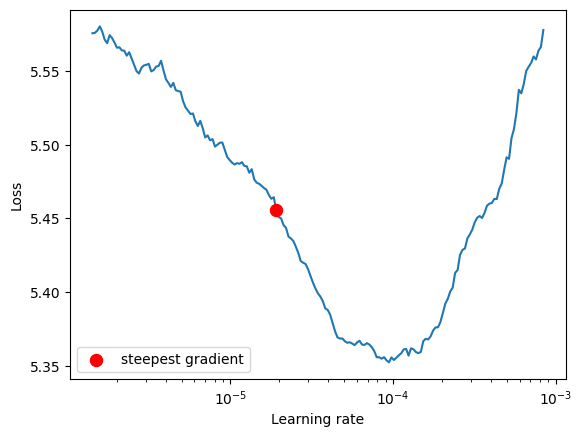

In [25]:
# Install if needed
!pip install torch-lr-finder

import torch.optim as optim
from torch_lr_finder import LRFinder



# Create fresh model and optimizer
model = resnet50_with_relu(num_classes=200)
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Run LR finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=0.001, num_iter=200)
lr_finder.plot()  # Shows the loss vs learning rate
lr_finder.reset()  # Reset model and optimizer

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.91e-5, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.91e-4,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

early_stop = EarlyStopping(
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_resnet50_tinyimagenet.pt"  # Updated name
)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)  # Use val_loader, not test_loader

    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

early_stop.load_best(model)
print("Training complete! Best val loss:", f"{early_stop.best:.4f}")

Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=0.66%, loss=5.3504]



Val E01: loss=5.2758, acc=86/10000 (0.86%)



Train E02: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=0.94%, loss=5.3750]



Val E02: loss=5.2304, acc=117/10000 (1.17%)



Train E03: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=1.72%, loss=5.0143]



Val E03: loss=5.0385, acc=253/10000 (2.53%)



Train E04: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=2.85%, loss=5.1039]



Val E04: loss=4.8564, acc=408/10000 (4.08%)



Train E05: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=4.42%, loss=4.4087]



Val E05: loss=4.6749, acc=581/10000 (5.81%)



Train E06: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=6.03%, loss=4.6228]



Val E06: loss=4.4909, acc=782/10000 (7.82%)



Train E07: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=8.23%, loss=4.9760]



Val E07: loss=4.3184, acc=929/10000 (9.29%)



Train E08: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=10.23%, loss=3.9854]



Val E08: loss=4.1412, acc=1224/10000 (12.24%)



Train E09: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=12.58%, loss=4.3132]



Val E09: loss=3.9861, acc=1447/10000 (14.47%)



Train E10: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=14.77%, loss=3.4317]



Val E10: loss=3.8595, acc=1614/10000 (16.14%)



Train E11: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=17.33%, loss=4.2162]



Val E11: loss=3.6940, acc=1888/10000 (18.88%)



Train E12: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=20.04%, loss=3.4173]



Val E12: loss=3.5591, acc=2127/10000 (21.27%)



Train E13: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=22.76%, loss=3.1391]



Val E13: loss=3.4204, acc=2322/10000 (23.22%)



Train E14: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=25.41%, loss=3.1162]



Val E14: loss=3.3702, acc=2477/10000 (24.77%)



Train E15: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=27.65%, loss=2.9271]



Val E15: loss=3.2212, acc=2742/10000 (27.42%)



Train E16: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=30.29%, loss=3.5622]



Val E16: loss=3.1179, acc=2953/10000 (29.53%)



Train E17:  42%|████▏     | 329/782 [00:51<01:09,  6.52it/s, acc=33.16%, loss=2.8838]

### resnet50 with relu (old lr)
**Observation**: now training converges almost same as resnet without relu, also stagnates around ~ 40%

In [10]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

early_stop = EarlyStopping(
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_resnet50_tinyimagenet.pt"  # Updated name
)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)  # Use val_loader, not test_loader

    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

early_stop.load_best(model)
print("Training complete! Best val loss:", f"{early_stop.best:.4f}")

Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 782/782 [02:00<00:00,  6.49it/s, acc=1.63%, loss=4.8896]



Val E01: loss=4.9007, acc=303/10000 (3.03%)



Train E02: 100%|██████████| 782/782 [02:00<00:00,  6.49it/s, acc=5.61%, loss=4.1797]



Val E02: loss=4.4278, acc=829/10000 (8.29%)



Train E03: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=9.48%, loss=4.6426]



Val E03: loss=4.1193, acc=1207/10000 (12.07%)



Train E04: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=13.21%, loss=4.2262]



Val E04: loss=3.9128, acc=1559/10000 (15.59%)



Train E05: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=16.84%, loss=3.6218]



Val E05: loss=3.6995, acc=1888/10000 (18.88%)



Train E06: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=19.83%, loss=3.4138]



Val E06: loss=3.5573, acc=2108/10000 (21.08%)



Train E07: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=22.60%, loss=3.5953]



Val E07: loss=3.4153, acc=2337/10000 (23.37%)



Train E08: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=25.19%, loss=3.5858]



Val E08: loss=3.2774, acc=2598/10000 (25.98%)



Train E09: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=27.61%, loss=2.9421]



Val E09: loss=3.2371, acc=2712/10000 (27.12%)



Train E10: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=29.77%, loss=2.2708]



Val E10: loss=3.1482, acc=2794/10000 (27.94%)



Train E11: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=32.08%, loss=2.8499]



Val E11: loss=3.1245, acc=2884/10000 (28.84%)



Train E12: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=34.12%, loss=2.6391]



Val E12: loss=3.0075, acc=3096/10000 (30.96%)



Train E13: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=36.62%, loss=3.1544]



Val E13: loss=2.9415, acc=3316/10000 (33.16%)



Train E14: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=38.85%, loss=3.4526]



Val E14: loss=2.8662, acc=3458/10000 (34.58%)



Train E15: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=41.08%, loss=2.9208]



Val E15: loss=2.8657, acc=3449/10000 (34.49%)



Train E16: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=43.72%, loss=2.8155]



Val E16: loss=2.6945, acc=3776/10000 (37.76%)



Train E17: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=46.17%, loss=2.4488]



Val E17: loss=2.7097, acc=3804/10000 (38.04%)



Train E18: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=48.64%, loss=2.3294]



Val E18: loss=2.6637, acc=3911/10000 (39.11%)



Train E19: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=51.43%, loss=2.1078]



Val E19: loss=2.6911, acc=3897/10000 (38.97%)



Train E20: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=54.30%, loss=2.2083]



Val E20: loss=2.7358, acc=3910/10000 (39.10%)



Train E21: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=57.25%, loss=1.9728]



Val E21: loss=2.9060, acc=3812/10000 (38.12%)



Train E22: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=60.27%, loss=1.5485]



Val E22: loss=2.7412, acc=4034/10000 (40.34%)



Train E23: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=63.42%, loss=1.8290]



Val E23: loss=2.9018, acc=3943/10000 (39.43%)



Train E24: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=66.56%, loss=1.4414]



Val E24: loss=2.9038, acc=4045/10000 (40.45%)



Train E25: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=69.77%, loss=1.6240]



Val E25: loss=2.9136, acc=4145/10000 (41.45%)



Train E26: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=72.73%, loss=1.5472]



Val E26: loss=3.0039, acc=4083/10000 (40.83%)



Train E27: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=75.35%, loss=0.8644]



Val E27: loss=3.2168, acc=3988/10000 (39.88%)



Train E28: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=78.00%, loss=0.7198]



Val E28: loss=3.1216, acc=4077/10000 (40.77%)



Train E29: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=80.23%, loss=1.0767]



Val E29: loss=3.2415, acc=4088/10000 (40.88%)



Train E30: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=81.81%, loss=1.0922]



Val E30: loss=3.3955, acc=3917/10000 (39.17%)



Train E31: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=83.72%, loss=1.0609]



Val E31: loss=3.4589, acc=4046/10000 (40.46%)



Train E32: 100%|██████████| 782/782 [02:10<00:00,  6.01it/s, acc=84.87%, loss=1.1387]



Val E32: loss=3.4582, acc=4019/10000 (40.19%)



Train E33: 100%|██████████| 782/782 [02:08<00:00,  6.08it/s, acc=86.42%, loss=0.6130]



Val E33: loss=3.4979, acc=4106/10000 (41.06%)

Early stopping at epoch 33. Best val loss: 2.6637
Training complete! Best val loss: 2.6637


### resnet50 with relu (old lr) + label smoothing
**Observation**: result are pushed passed 41% accuracy, need to run further epochs

In [12]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

early_stop = EarlyStopping(
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_resnet50_tinyimagenet.pt"  # Updated name
)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)  # Use val_loader, not test_loader

    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

early_stop.load_best(model)
print("Training complete! Best val loss:", f"{early_stop.best:.4f}")

Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 782/782 [02:03<00:00,  6.32it/s, acc=1.74%, loss=4.9383]



Val E01: loss=4.9687, acc=407/10000 (4.07%)



Train E02: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=5.55%, loss=4.4309]



Val E02: loss=4.6165, acc=842/10000 (8.42%)



Train E03: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=9.42%, loss=4.8296]



Val E03: loss=4.3996, acc=1145/10000 (11.45%)



Train E04: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=12.95%, loss=4.2652]



Val E04: loss=4.1864, acc=1497/10000 (14.97%)



Train E05: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=16.00%, loss=4.2334]



Val E05: loss=4.0597, acc=1801/10000 (18.01%)



Train E06: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=19.05%, loss=4.0135]



Val E06: loss=3.8800, acc=2131/10000 (21.31%)



Train E07: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=22.08%, loss=3.7014]



Val E07: loss=3.8051, acc=2283/10000 (22.83%)



Train E08: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=24.83%, loss=3.7328]



Val E08: loss=3.7284, acc=2460/10000 (24.60%)



Train E09: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=27.47%, loss=3.2232]



Val E09: loss=3.6631, acc=2607/10000 (26.07%)



Train E10: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=29.81%, loss=2.8742]



Val E10: loss=3.5260, acc=2863/10000 (28.63%)



Train E11: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=32.04%, loss=3.0724]



Val E11: loss=3.6116, acc=2830/10000 (28.30%)



Train E12: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=34.56%, loss=3.7510]



Val E12: loss=3.3832, acc=3244/10000 (32.44%)



Train E13: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=36.78%, loss=2.7116]



Val E13: loss=3.3154, acc=3406/10000 (34.06%)



Train E14: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=39.35%, loss=3.1733]



Val E14: loss=3.3409, acc=3371/10000 (33.71%)



Train E15: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=41.66%, loss=3.0540]



Val E15: loss=3.3003, acc=3489/10000 (34.89%)



Train E16: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=44.51%, loss=3.0591]



Val E16: loss=3.1936, acc=3718/10000 (37.18%)



Train E17: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s, acc=47.15%, loss=2.6246]



Val E17: loss=3.1157, acc=3934/10000 (39.34%)



Train E18: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=49.71%, loss=2.8271]



Val E18: loss=3.1499, acc=3849/10000 (38.49%)



Train E19: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=52.49%, loss=2.8465]



Val E19: loss=3.1541, acc=3921/10000 (39.21%)



Train E20: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=55.84%, loss=2.7419]



Val E20: loss=3.1059, acc=4076/10000 (40.76%)



Train E21: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=58.72%, loss=2.0978]



Val E21: loss=3.0747, acc=4164/10000 (41.64%)



Train E22: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=62.26%, loss=2.0630]



Val E22: loss=3.0881, acc=4223/10000 (42.23%)



Train E23: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=65.41%, loss=2.6544]



Val E23: loss=3.1552, acc=4188/10000 (41.88%)



Train E24: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=69.05%, loss=2.1671]



Val E24: loss=3.2034, acc=4116/10000 (41.16%)



Train E25: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=72.66%, loss=1.5841]



Val E25: loss=3.3054, acc=3946/10000 (39.46%)



Train E26: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=75.84%, loss=1.9074]



Val E26: loss=3.2483, acc=4171/10000 (41.71%)



Train E27: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=79.06%, loss=1.7595]



Val E27: loss=3.3295, acc=4065/10000 (40.65%)



Train E28: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=81.71%, loss=1.5377]



Val E28: loss=3.2972, acc=4147/10000 (41.47%)



Train E29: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=83.97%, loss=1.4778]



Val E29: loss=3.3198, acc=4141/10000 (41.41%)



Train E30: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=86.03%, loss=1.4807]



Val E30: loss=3.3011, acc=4236/10000 (42.36%)



Train E31: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=87.64%, loss=1.6798]



Val E31: loss=3.3202, acc=4202/10000 (42.02%)



Train E32: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=89.03%, loss=1.5889]



Val E32: loss=3.2860, acc=4275/10000 (42.75%)



Train E33: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=90.07%, loss=1.5498]



Val E33: loss=3.2900, acc=4268/10000 (42.68%)



Train E34: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=91.16%, loss=1.5270]



Val E34: loss=3.2717, acc=4291/10000 (42.91%)



Train E35: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=92.11%, loss=1.2664]



Val E35: loss=3.2802, acc=4297/10000 (42.97%)



Train E36: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=92.81%, loss=1.3279]



Val E36: loss=3.2956, acc=4243/10000 (42.43%)

Early stopping at epoch 36. Best val loss: 3.0747
Training complete! Best val loss: 3.0747


### resnet50 with relu (old lr) + label smoothing
**Observation**: ran to95 epochs ~47% accuracy reached, huge gap b/w test and train need to increase weight decay

In [12]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': val_acc,
            'loss': val_loss
        }, checkpoint_path)
        print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")

Device: cuda


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=1.67%, loss=5.1633]



Val E01: loss=4.9796, acc=389/10000 (3.89%)

✓ Saved best model at epoch 1 with accuracy: 3.89%


Train E02: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=5.49%, loss=4.8673]



Val E02: loss=4.6268, acc=817/10000 (8.17%)

✓ Saved best model at epoch 2 with accuracy: 8.17%


Train E03: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=9.48%, loss=4.7146]



Val E03: loss=4.3693, acc=1211/10000 (12.11%)

✓ Saved best model at epoch 3 with accuracy: 12.11%


Train E04: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=13.03%, loss=4.3109]



Val E04: loss=4.2050, acc=1475/10000 (14.75%)

✓ Saved best model at epoch 4 with accuracy: 14.75%


Train E05: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=16.09%, loss=3.9055]



Val E05: loss=4.0452, acc=1829/10000 (18.29%)

✓ Saved best model at epoch 5 with accuracy: 18.29%


Train E06: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=19.43%, loss=4.2301]



Val E06: loss=3.9803, acc=2033/10000 (20.33%)

✓ Saved best model at epoch 6 with accuracy: 20.33%


Train E07: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=22.53%, loss=4.4503]



Val E07: loss=3.7876, acc=2370/10000 (23.70%)

✓ Saved best model at epoch 7 with accuracy: 23.70%


Train E08: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=24.94%, loss=4.1062]



Val E08: loss=3.6668, acc=2621/10000 (26.21%)

✓ Saved best model at epoch 8 with accuracy: 26.21%


Train E09: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=27.59%, loss=3.5209]



Val E09: loss=3.6208, acc=2697/10000 (26.97%)

✓ Saved best model at epoch 9 with accuracy: 26.97%


Train E10: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=29.92%, loss=3.8236]



Val E10: loss=3.5169, acc=2917/10000 (29.17%)

✓ Saved best model at epoch 10 with accuracy: 29.17%


Train E11: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=32.29%, loss=3.6250]



Val E11: loss=3.4702, acc=3004/10000 (30.04%)

✓ Saved best model at epoch 11 with accuracy: 30.04%


Train E12: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=34.61%, loss=3.0609]



Val E12: loss=3.3653, acc=3249/10000 (32.49%)

✓ Saved best model at epoch 12 with accuracy: 32.49%


Train E13: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=36.75%, loss=3.4760]



Val E13: loss=3.3358, acc=3351/10000 (33.51%)

✓ Saved best model at epoch 13 with accuracy: 33.51%


Train E14: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=39.20%, loss=3.2763]



Val E14: loss=3.2985, acc=3475/10000 (34.75%)

✓ Saved best model at epoch 14 with accuracy: 34.75%


Train E15: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=41.78%, loss=3.1704]



Val E15: loss=3.2380, acc=3616/10000 (36.16%)

✓ Saved best model at epoch 15 with accuracy: 36.16%


Train E16: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=44.21%, loss=3.0614]



Val E16: loss=3.2105, acc=3688/10000 (36.88%)

✓ Saved best model at epoch 16 with accuracy: 36.88%


Train E17: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s, acc=46.96%, loss=3.0303]



Val E17: loss=3.1555, acc=3884/10000 (38.84%)

✓ Saved best model at epoch 17 with accuracy: 38.84%


Train E18: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=49.72%, loss=2.0788]



Val E18: loss=3.1397, acc=3958/10000 (39.58%)

✓ Saved best model at epoch 18 with accuracy: 39.58%


Train E19: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=52.48%, loss=3.2135]



Val E19: loss=3.1092, acc=4001/10000 (40.01%)

✓ Saved best model at epoch 19 with accuracy: 40.01%


Train E20: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=55.60%, loss=2.8304]



Val E20: loss=3.0900, acc=4150/10000 (41.50%)

✓ Saved best model at epoch 20 with accuracy: 41.50%


Train E21: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=58.83%, loss=2.6420]



Val E21: loss=3.1481, acc=4037/10000 (40.37%)



Train E22: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=62.23%, loss=2.2987]



Val E22: loss=3.0919, acc=4234/10000 (42.34%)

✓ Saved best model at epoch 22 with accuracy: 42.34%


Train E23: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s, acc=65.91%, loss=2.6177]



Val E23: loss=3.1944, acc=4079/10000 (40.79%)



Train E24: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=69.36%, loss=2.2617]



Val E24: loss=3.1588, acc=4209/10000 (42.09%)



Train E25: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=72.97%, loss=1.9273]



Val E25: loss=3.1697, acc=4244/10000 (42.44%)

✓ Saved best model at epoch 25 with accuracy: 42.44%


Train E26: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=76.23%, loss=1.6487]



Val E26: loss=3.2614, acc=4146/10000 (41.46%)



Train E27: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=79.45%, loss=2.0269]



Val E27: loss=3.2792, acc=4145/10000 (41.45%)



Train E28: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=82.19%, loss=1.7908]



Val E28: loss=3.2737, acc=4177/10000 (41.77%)



Train E29: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=84.49%, loss=1.7695]



Val E29: loss=3.3175, acc=4077/10000 (40.77%)



Train E30: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=86.14%, loss=1.3153]



Val E30: loss=3.3116, acc=4098/10000 (40.98%)



Train E31: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=88.02%, loss=1.6143]



Val E31: loss=3.3343, acc=4159/10000 (41.59%)



Train E32: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=89.26%, loss=1.4865]



Val E32: loss=3.3254, acc=4185/10000 (41.85%)



Train E33: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=90.17%, loss=1.6430]



Val E33: loss=3.2662, acc=4201/10000 (42.01%)



Train E34: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=91.42%, loss=1.3320]



Val E34: loss=3.2729, acc=4297/10000 (42.97%)

✓ Saved best model at epoch 34 with accuracy: 42.97%


Train E35: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=91.99%, loss=1.3239]



Val E35: loss=3.2908, acc=4254/10000 (42.54%)



Train E36: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=92.86%, loss=1.4223]



Val E36: loss=3.2582, acc=4264/10000 (42.64%)



Train E37: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=93.78%, loss=1.2720]



Val E37: loss=3.2795, acc=4290/10000 (42.90%)



Train E38: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=93.99%, loss=1.2546]



Val E38: loss=3.2672, acc=4308/10000 (43.08%)

✓ Saved best model at epoch 38 with accuracy: 43.08%


Train E39: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=94.72%, loss=1.4471]



Val E39: loss=3.2395, acc=4327/10000 (43.27%)

✓ Saved best model at epoch 39 with accuracy: 43.27%


Train E40: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=95.09%, loss=1.4067]



Val E40: loss=3.3191, acc=4218/10000 (42.18%)



Train E41: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=95.40%, loss=1.2709]



Val E41: loss=3.2527, acc=4291/10000 (42.91%)



Train E42: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=95.88%, loss=1.3617]



Val E42: loss=3.2561, acc=4276/10000 (42.76%)



Train E43: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=96.29%, loss=1.1024]



Val E43: loss=3.2590, acc=4301/10000 (43.01%)



Train E44: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=96.61%, loss=1.2141]



Val E44: loss=3.1939, acc=4415/10000 (44.15%)

✓ Saved best model at epoch 44 with accuracy: 44.15%


Train E45: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=96.95%, loss=1.3418]



Val E45: loss=3.1982, acc=4400/10000 (44.00%)



Train E46: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=97.13%, loss=1.2359]



Val E46: loss=3.2197, acc=4376/10000 (43.76%)



Train E47: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=97.42%, loss=1.1886]



Val E47: loss=3.1978, acc=4426/10000 (44.26%)

✓ Saved best model at epoch 47 with accuracy: 44.26%


Train E48: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=97.51%, loss=1.1720]



Val E48: loss=3.1812, acc=4437/10000 (44.37%)

✓ Saved best model at epoch 48 with accuracy: 44.37%


Train E49: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=97.79%, loss=1.0545]



Val E49: loss=3.1667, acc=4512/10000 (45.12%)

✓ Saved best model at epoch 49 with accuracy: 45.12%


Train E50: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=98.03%, loss=1.0509]



Val E50: loss=3.1634, acc=4508/10000 (45.08%)



Train E51: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=98.22%, loss=1.3446]



Val E51: loss=3.1629, acc=4504/10000 (45.04%)



Train E52: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=98.32%, loss=1.0267]



Val E52: loss=3.1617, acc=4483/10000 (44.83%)



Train E53: 100%|██████████| 782/782 [02:03<00:00,  6.36it/s, acc=98.51%, loss=1.0381]



Val E53: loss=3.1695, acc=4444/10000 (44.44%)



Train E54: 100%|██████████| 782/782 [02:03<00:00,  6.35it/s, acc=98.59%, loss=1.1303]



Val E54: loss=3.1487, acc=4518/10000 (45.18%)

✓ Saved best model at epoch 54 with accuracy: 45.18%


Train E55: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=98.66%, loss=1.1970]



Val E55: loss=3.1414, acc=4530/10000 (45.30%)

✓ Saved best model at epoch 55 with accuracy: 45.30%


Train E56: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=98.88%, loss=1.0355]



Val E56: loss=3.1358, acc=4503/10000 (45.03%)



Train E57: 100%|██████████| 782/782 [02:03<00:00,  6.35it/s, acc=98.95%, loss=1.0147]



Val E57: loss=3.1179, acc=4574/10000 (45.74%)

✓ Saved best model at epoch 57 with accuracy: 45.74%


Train E58: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=99.04%, loss=1.0476]



Val E58: loss=3.1329, acc=4511/10000 (45.11%)



Train E59: 100%|██████████| 782/782 [02:03<00:00,  6.35it/s, acc=99.15%, loss=1.0908]



Val E59: loss=3.1025, acc=4598/10000 (45.98%)

✓ Saved best model at epoch 59 with accuracy: 45.98%


Train E60: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s, acc=99.23%, loss=1.1095]



Val E60: loss=3.1113, acc=4535/10000 (45.35%)



Train E61: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s, acc=99.26%, loss=0.9805]



Val E61: loss=3.1029, acc=4600/10000 (46.00%)

✓ Saved best model at epoch 61 with accuracy: 46.00%


Train E62: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=99.33%, loss=0.9336]



Val E62: loss=3.0889, acc=4612/10000 (46.12%)

✓ Saved best model at epoch 62 with accuracy: 46.12%


Train E63: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=99.38%, loss=1.0457]



Val E63: loss=3.1066, acc=4593/10000 (45.93%)



Train E64: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=99.49%, loss=0.9380]



Val E64: loss=3.0934, acc=4612/10000 (46.12%)



Train E65: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=99.53%, loss=1.0073]



Val E65: loss=3.1036, acc=4574/10000 (45.74%)



Train E66: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=99.47%, loss=0.9745]



Val E66: loss=3.1108, acc=4570/10000 (45.70%)



Train E67: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=99.52%, loss=0.9776]



Val E67: loss=3.1107, acc=4570/10000 (45.70%)



Train E68: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=99.59%, loss=0.9915]



Val E68: loss=3.0797, acc=4637/10000 (46.37%)

✓ Saved best model at epoch 68 with accuracy: 46.37%


Train E69: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=99.65%, loss=1.0496]



Val E69: loss=3.0826, acc=4635/10000 (46.35%)



Train E70: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=99.68%, loss=0.9645]



Val E70: loss=3.0859, acc=4657/10000 (46.57%)

✓ Saved best model at epoch 70 with accuracy: 46.57%


Train E71: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=99.69%, loss=0.9218]



Val E71: loss=3.0811, acc=4688/10000 (46.88%)

✓ Saved best model at epoch 71 with accuracy: 46.88%


Train E72: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=99.73%, loss=1.2205]



Val E72: loss=3.0846, acc=4701/10000 (47.01%)

✓ Saved best model at epoch 72 with accuracy: 47.01%


Train E73: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=99.73%, loss=0.8969]



Val E73: loss=3.0938, acc=4655/10000 (46.55%)



Train E74: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=99.79%, loss=0.9384]



Val E74: loss=3.0744, acc=4666/10000 (46.66%)



Train E75: 100%|██████████| 782/782 [02:02<00:00,  6.39it/s, acc=99.79%, loss=0.9577]



Val E75: loss=3.0750, acc=4687/10000 (46.87%)



Train E76: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=99.82%, loss=1.0001]



Val E76: loss=3.0776, acc=4657/10000 (46.57%)



Train E77: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=99.83%, loss=0.9350]



Val E77: loss=3.0714, acc=4710/10000 (47.10%)

✓ Saved best model at epoch 77 with accuracy: 47.10%


Train E78: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, acc=99.84%, loss=0.9488]



Val E78: loss=3.0760, acc=4684/10000 (46.84%)



Train E79: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=99.83%, loss=0.9657]



Val E79: loss=3.0738, acc=4684/10000 (46.84%)



Train E80: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=99.86%, loss=0.8942]



Val E80: loss=3.0673, acc=4732/10000 (47.32%)

✓ Saved best model at epoch 80 with accuracy: 47.32%


Train E81: 100%|██████████| 782/782 [02:01<00:00,  6.41it/s, acc=99.88%, loss=0.9482]



Val E81: loss=3.0727, acc=4672/10000 (46.72%)



Train E82: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=99.88%, loss=1.0966]



Val E82: loss=3.0757, acc=4706/10000 (47.06%)



Train E83: 100%|██████████| 782/782 [02:02<00:00,  6.37it/s, acc=99.89%, loss=0.9337]



Val E83: loss=3.0802, acc=4695/10000 (46.95%)



Train E84: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=99.90%, loss=0.9121]



Val E84: loss=3.0733, acc=4733/10000 (47.33%)

✓ Saved best model at epoch 84 with accuracy: 47.33%


Train E85: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=99.89%, loss=0.9120]



Val E85: loss=3.0744, acc=4703/10000 (47.03%)



Train E86: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=99.92%, loss=0.9422]



Val E86: loss=3.0808, acc=4696/10000 (46.96%)



Train E87: 100%|██████████| 782/782 [02:01<00:00,  6.44it/s, acc=99.90%, loss=0.9492]



Val E87: loss=3.0697, acc=4719/10000 (47.19%)



Train E88: 100%|██████████| 782/782 [02:02<00:00,  6.41it/s, acc=99.93%, loss=0.9111]



Val E88: loss=3.0703, acc=4753/10000 (47.53%)

✓ Saved best model at epoch 88 with accuracy: 47.53%


Train E89: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s, acc=99.94%, loss=0.9578]



Val E89: loss=3.0700, acc=4741/10000 (47.41%)



Train E90: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=99.91%, loss=0.9827]



Val E90: loss=3.0706, acc=4740/10000 (47.40%)



Train E91: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=99.93%, loss=0.9920]



Val E91: loss=3.0689, acc=4732/10000 (47.32%)



Train E92: 100%|██████████| 782/782 [02:01<00:00,  6.45it/s, acc=99.92%, loss=0.8885]



Val E92: loss=3.0801, acc=4726/10000 (47.26%)



Train E93: 100%|██████████| 782/782 [02:01<00:00,  6.42it/s, acc=99.95%, loss=0.9338]



Val E93: loss=3.0760, acc=4738/10000 (47.38%)



Train E94: 100%|██████████| 782/782 [02:01<00:00,  6.43it/s, acc=99.94%, loss=0.9786]



Val E94: loss=3.0784, acc=4730/10000 (47.30%)



Train E95:  92%|█████████▏| 718/782 [01:51<00:09,  6.43it/s, acc=99.93%, loss=0.8719]


KeyboardInterrupt: 

In [11]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': val_acc,
            'loss': val_loss
        }, checkpoint_path)
        print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")

Device: cuda


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
Train E01: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=1.82%, loss=5.0179]



Val E01: loss=4.9599, acc=385/10000 (3.85%)

✓ Saved best model at epoch 1 with accuracy: 3.85%


Train E02: 100%|██████████| 782/782 [01:57<00:00,  6.65it/s, acc=5.56%, loss=4.9994]



Val E02: loss=4.5706, acc=905/10000 (9.05%)

✓ Saved best model at epoch 2 with accuracy: 9.05%


Train E03: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, acc=9.62%, loss=4.5856]



Val E03: loss=4.3587, acc=1208/10000 (12.08%)

✓ Saved best model at epoch 3 with accuracy: 12.08%


Train E04: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=12.90%, loss=4.1467]



Val E04: loss=4.1614, acc=1612/10000 (16.12%)

✓ Saved best model at epoch 4 with accuracy: 16.12%


Train E05: 100%|██████████| 782/782 [01:57<00:00,  6.65it/s, acc=16.75%, loss=4.4397]



Val E05: loss=4.0377, acc=1853/10000 (18.53%)

✓ Saved best model at epoch 5 with accuracy: 18.53%


Train E06: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=19.92%, loss=3.9750]



Val E06: loss=3.9015, acc=2124/10000 (21.24%)

✓ Saved best model at epoch 6 with accuracy: 21.24%


Train E07: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=22.58%, loss=4.5005]



Val E07: loss=3.7459, acc=2397/10000 (23.97%)

✓ Saved best model at epoch 7 with accuracy: 23.97%


Train E08: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=25.15%, loss=3.6219]



Val E08: loss=3.7096, acc=2490/10000 (24.90%)

✓ Saved best model at epoch 8 with accuracy: 24.90%


Train E09: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=27.75%, loss=4.0779]



Val E09: loss=3.5391, acc=2922/10000 (29.22%)

✓ Saved best model at epoch 9 with accuracy: 29.22%


Train E10: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=30.02%, loss=3.0319]



Val E10: loss=3.6093, acc=2706/10000 (27.06%)



Train E11: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=32.15%, loss=3.6726]



Val E11: loss=3.5279, acc=2924/10000 (29.24%)

✓ Saved best model at epoch 11 with accuracy: 29.24%


Train E12: 100%|██████████| 782/782 [01:57<00:00,  6.68it/s, acc=34.56%, loss=3.4921]



Val E12: loss=3.3894, acc=3207/10000 (32.07%)

✓ Saved best model at epoch 12 with accuracy: 32.07%


Train E13: 100%|██████████| 782/782 [01:57<00:00,  6.68it/s, acc=36.97%, loss=3.8674]



Val E13: loss=3.3344, acc=3383/10000 (33.83%)

✓ Saved best model at epoch 13 with accuracy: 33.83%


Train E14: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=39.17%, loss=4.0055]



Val E14: loss=3.2969, acc=3476/10000 (34.76%)

✓ Saved best model at epoch 14 with accuracy: 34.76%


Train E15: 100%|██████████| 782/782 [01:57<00:00,  6.65it/s, acc=41.94%, loss=2.5115]



Val E15: loss=3.2135, acc=3654/10000 (36.54%)

✓ Saved best model at epoch 15 with accuracy: 36.54%


Train E16: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, acc=44.33%, loss=3.0153]



Val E16: loss=3.2132, acc=3627/10000 (36.27%)



Train E17: 100%|██████████| 782/782 [01:57<00:00,  6.63it/s, acc=46.87%, loss=3.1731]



Val E17: loss=3.1276, acc=3898/10000 (38.98%)

✓ Saved best model at epoch 17 with accuracy: 38.98%


Train E18: 100%|██████████| 782/782 [01:57<00:00,  6.63it/s, acc=49.77%, loss=3.2584]



Val E18: loss=3.1670, acc=3883/10000 (38.83%)



Train E19: 100%|██████████| 782/782 [01:58<00:00,  6.61it/s, acc=52.53%, loss=2.7120]



Val E19: loss=3.2424, acc=3838/10000 (38.38%)



Train E20: 100%|██████████| 782/782 [01:57<00:00,  6.65it/s, acc=55.60%, loss=2.6587]



Val E20: loss=3.0785, acc=4147/10000 (41.47%)

✓ Saved best model at epoch 20 with accuracy: 41.47%


Train E21: 100%|██████████| 782/782 [01:58<00:00,  6.62it/s, acc=58.76%, loss=2.6575]



Val E21: loss=3.1312, acc=4064/10000 (40.64%)



Train E22: 100%|██████████| 782/782 [01:58<00:00,  6.61it/s, acc=62.19%, loss=2.5540]



Val E22: loss=3.1648, acc=4028/10000 (40.28%)



Train E23: 100%|██████████| 782/782 [01:57<00:00,  6.63it/s, acc=65.68%, loss=2.6594]



Val E23: loss=3.2312, acc=4054/10000 (40.54%)



Train E24: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, acc=69.25%, loss=1.8907]



Val E24: loss=3.2574, acc=4025/10000 (40.25%)



Train E25: 100%|██████████| 782/782 [01:58<00:00,  6.61it/s, acc=73.05%, loss=2.1099]



Val E25: loss=3.2282, acc=4103/10000 (41.03%)



Train E26: 100%|██████████| 782/782 [01:57<00:00,  6.63it/s, acc=76.81%, loss=2.0101]



Val E26: loss=3.2810, acc=4100/10000 (41.00%)



Train E27: 100%|██████████| 782/782 [01:57<00:00,  6.63it/s, acc=79.26%, loss=1.9373]



Val E27: loss=3.2884, acc=4136/10000 (41.36%)



Train E28: 100%|██████████| 782/782 [01:57<00:00,  6.68it/s, acc=82.01%, loss=1.7969]



Val E28: loss=3.3100, acc=4093/10000 (40.93%)



Train E29: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=84.29%, loss=1.5962]



Val E29: loss=3.3776, acc=3988/10000 (39.88%)



Train E30: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=86.23%, loss=1.6083]



Val E30: loss=3.3315, acc=4108/10000 (41.08%)



Train E31: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=87.79%, loss=1.6128]



Val E31: loss=3.3424, acc=4070/10000 (40.70%)



Train E32: 100%|██████████| 782/782 [01:57<00:00,  6.65it/s, acc=89.08%, loss=1.6263]



Val E32: loss=3.3343, acc=4106/10000 (41.06%)



Train E33: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, acc=90.19%, loss=1.5013]



Val E33: loss=3.3078, acc=4185/10000 (41.85%)

✓ Saved best model at epoch 33 with accuracy: 41.85%


Train E34: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=91.29%, loss=1.3433]



Val E34: loss=3.3285, acc=4183/10000 (41.83%)



Train E35: 100%|██████████| 782/782 [01:57<00:00,  6.65it/s, acc=92.02%, loss=1.2736]



Val E35: loss=3.3327, acc=4195/10000 (41.95%)

✓ Saved best model at epoch 35 with accuracy: 41.95%


Train E36: 100%|██████████| 782/782 [01:57<00:00,  6.63it/s, acc=92.75%, loss=1.2718]



Val E36: loss=3.3019, acc=4224/10000 (42.24%)

✓ Saved best model at epoch 36 with accuracy: 42.24%


Train E37: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=93.75%, loss=1.6821]



Val E37: loss=3.3286, acc=4200/10000 (42.00%)



Train E38: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, acc=94.05%, loss=1.5962]



Val E38: loss=3.3055, acc=4196/10000 (41.96%)



Train E39: 100%|██████████| 782/782 [01:58<00:00,  6.59it/s, acc=94.53%, loss=1.2967]



Val E39: loss=3.3577, acc=4089/10000 (40.89%)



Train E40: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, acc=94.94%, loss=1.2689]



Val E40: loss=3.2728, acc=4250/10000 (42.50%)

✓ Saved best model at epoch 40 with accuracy: 42.50%


Train E41: 100%|██████████| 782/782 [01:57<00:00,  6.68it/s, acc=95.62%, loss=1.5014]



Val E41: loss=3.2643, acc=4262/10000 (42.62%)

✓ Saved best model at epoch 41 with accuracy: 42.62%


Train E42: 100%|██████████| 782/782 [01:56<00:00,  6.70it/s, acc=95.97%, loss=1.2983]



Val E42: loss=3.2441, acc=4297/10000 (42.97%)

✓ Saved best model at epoch 42 with accuracy: 42.97%


Train E43: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=96.28%, loss=1.2487]



Val E43: loss=3.2318, acc=4307/10000 (43.07%)

✓ Saved best model at epoch 43 with accuracy: 43.07%


Train E44: 100%|██████████| 782/782 [01:57<00:00,  6.63it/s, acc=96.64%, loss=1.1894]



Val E44: loss=3.2618, acc=4257/10000 (42.57%)



Train E45: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, acc=97.05%, loss=1.2415]



Val E45: loss=3.2255, acc=4306/10000 (43.06%)



Train E46: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, acc=97.11%, loss=1.5114]



Val E46: loss=3.2330, acc=4291/10000 (42.91%)



Train E47: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, acc=97.36%, loss=1.2314]



Val E47: loss=3.2308, acc=4300/10000 (43.00%)



Train E48: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=97.58%, loss=1.0558]



Val E48: loss=3.2321, acc=4328/10000 (43.28%)

✓ Saved best model at epoch 48 with accuracy: 43.28%


Train E49: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=97.78%, loss=1.2280]



Val E49: loss=3.1983, acc=4390/10000 (43.90%)

✓ Saved best model at epoch 49 with accuracy: 43.90%


Train E50: 100%|██████████| 782/782 [01:58<00:00,  6.63it/s, acc=98.02%, loss=1.0450]



Val E50: loss=3.1870, acc=4396/10000 (43.96%)

✓ Saved best model at epoch 50 with accuracy: 43.96%


Train E51: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s, acc=98.22%, loss=1.1439]



Val E51: loss=3.1821, acc=4399/10000 (43.99%)

✓ Saved best model at epoch 51 with accuracy: 43.99%


Train E52: 100%|██████████| 782/782 [01:56<00:00,  6.70it/s, acc=98.34%, loss=1.1349]



Val E52: loss=3.1794, acc=4405/10000 (44.05%)

✓ Saved best model at epoch 52 with accuracy: 44.05%


Train E53: 100%|██████████| 782/782 [01:56<00:00,  6.72it/s, acc=98.40%, loss=1.0133]



Val E53: loss=3.1651, acc=4404/10000 (44.04%)



Train E54: 100%|██████████| 782/782 [01:56<00:00,  6.71it/s, acc=98.58%, loss=1.0394]


KeyboardInterrupt: 

### with mixed precision training

In [15]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

scaler = GradScaler()  # Create scaler before the loop

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler)
    val_loss, val_acc = test(model, device, val_loader, epoch)

    # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")

Device: cuda


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/tmp/ipython-input-4043448058.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Create scaler before the loop
Train E01:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-3981817222.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/to


Val E01: loss=4.9617, acc=370/10000 (3.70%)



Train E02: 100%|██████████| 782/782 [01:35<00:00,  8.15it/s, acc=5.46%, loss=4.7547]



Val E02: loss=4.6186, acc=805/10000 (8.05%)



Train E03: 100%|██████████| 782/782 [01:33<00:00,  8.34it/s, acc=9.31%, loss=4.5091]



Val E03: loss=4.3851, acc=1197/10000 (11.97%)



Train E04: 100%|██████████| 782/782 [01:33<00:00,  8.41it/s, acc=12.69%, loss=4.4002]



Val E04: loss=4.1966, acc=1521/10000 (15.21%)



Train E05: 100%|██████████| 782/782 [01:32<00:00,  8.41it/s, acc=15.72%, loss=4.2046]



Val E05: loss=4.0786, acc=1783/10000 (17.83%)



Train E06: 100%|██████████| 782/782 [01:34<00:00,  8.32it/s, acc=18.90%, loss=3.6696]



Val E06: loss=3.8893, acc=2114/10000 (21.14%)



Train E07: 100%|██████████| 782/782 [01:35<00:00,  8.20it/s, acc=21.87%, loss=3.9468]



Val E07: loss=3.8051, acc=2325/10000 (23.25%)



Train E08: 100%|██████████| 782/782 [01:36<00:00,  8.08it/s, acc=24.79%, loss=4.0485]



Val E08: loss=3.7096, acc=2558/10000 (25.58%)



Train E09: 100%|██████████| 782/782 [01:35<00:00,  8.19it/s, acc=27.37%, loss=3.3826]



Val E09: loss=3.6225, acc=2684/10000 (26.84%)



Train E10: 100%|██████████| 782/782 [01:34<00:00,  8.26it/s, acc=29.85%, loss=3.8896]



Val E10: loss=3.5509, acc=2870/10000 (28.70%)



Train E11: 100%|██████████| 782/782 [01:33<00:00,  8.35it/s, acc=32.23%, loss=3.3962]



Val E11: loss=3.5365, acc=2960/10000 (29.60%)



Train E12: 100%|██████████| 782/782 [01:34<00:00,  8.30it/s, acc=34.44%, loss=3.8060]



Val E12: loss=3.4492, acc=3102/10000 (31.02%)



Train E13: 100%|██████████| 782/782 [01:35<00:00,  8.18it/s, acc=36.85%, loss=3.3362]



Val E13: loss=3.3000, acc=3416/10000 (34.16%)



Train E14: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=39.22%, loss=3.4867]



Val E14: loss=3.2922, acc=3446/10000 (34.46%)



Train E15: 100%|██████████| 782/782 [01:33<00:00,  8.37it/s, acc=41.99%, loss=2.9979]



Val E15: loss=3.2455, acc=3678/10000 (36.78%)



Train E16: 100%|██████████| 782/782 [01:35<00:00,  8.17it/s, acc=44.29%, loss=3.0034]



Val E16: loss=3.1530, acc=3833/10000 (38.33%)



Train E17: 100%|██████████| 782/782 [01:34<00:00,  8.29it/s, acc=47.10%, loss=3.0496]



Val E17: loss=3.1384, acc=3837/10000 (38.37%)



Train E18: 100%|██████████| 782/782 [01:35<00:00,  8.18it/s, acc=49.64%, loss=2.7743]



Val E18: loss=3.1085, acc=3926/10000 (39.26%)



Train E19: 100%|██████████| 782/782 [01:38<00:00,  7.93it/s, acc=52.73%, loss=2.4099]



Val E19: loss=3.0893, acc=4072/10000 (40.72%)



Train E20: 100%|██████████| 782/782 [01:34<00:00,  8.32it/s, acc=55.34%, loss=2.4950]



Val E20: loss=3.0588, acc=4164/10000 (41.64%)



Train E21: 100%|██████████| 782/782 [01:35<00:00,  8.15it/s, acc=58.81%, loss=1.9943]



Val E21: loss=3.1148, acc=4054/10000 (40.54%)

✓ Saved best model at epoch 21 with accuracy: 40.54%


Train E22: 100%|██████████| 782/782 [01:33<00:00,  8.32it/s, acc=62.25%, loss=2.1742]



Val E22: loss=3.1422, acc=4119/10000 (41.19%)

✓ Saved best model at epoch 22 with accuracy: 41.19%


Train E23: 100%|██████████| 782/782 [01:36<00:00,  8.14it/s, acc=65.61%, loss=2.0338]



Val E23: loss=3.1611, acc=4088/10000 (40.88%)



Train E24: 100%|██████████| 782/782 [01:34<00:00,  8.29it/s, acc=68.72%, loss=1.6196]



Val E24: loss=3.1359, acc=4236/10000 (42.36%)

✓ Saved best model at epoch 24 with accuracy: 42.36%


Train E25: 100%|██████████| 782/782 [01:32<00:00,  8.42it/s, acc=72.37%, loss=1.8900]



Val E25: loss=3.2542, acc=4063/10000 (40.63%)



Train E26: 100%|██████████| 782/782 [01:31<00:00,  8.54it/s, acc=75.86%, loss=1.7107]



Val E26: loss=3.2403, acc=4161/10000 (41.61%)



Train E27: 100%|██████████| 782/782 [01:35<00:00,  8.17it/s, acc=78.49%, loss=1.6175]



Val E27: loss=3.2952, acc=4045/10000 (40.45%)



Train E28:   1%|          | 9/782 [00:01<02:03,  6.26it/s, acc=81.60%, loss=1.5320]


KeyboardInterrupt: 

### Misclassification Analysis

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_acc, label='Train Acc')
    ax2.plot(test_acc, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def analyze_misclassifications(model, device, test_loader, class_names, top_k=5):
    model.eval()

    # Track misclassifications per class
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    misclassified_images = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            for i in range(len(target)):
                label = target[i].item()
                class_total[label] += 1
                if pred[i] == label:
                    class_correct[label] += 1
                else:
                    # Store misclassified examples
                    misclassified_images.append({
                        'image': data[i].cpu(),
                        'true': label,
                        'pred': pred[i].item(),
                        'conf': torch.softmax(output[i], dim=0).max().item()
                    })

    # Calculate accuracy per class
    class_accuracy = [(100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0)
                      for i in range(len(class_names))]

    # Find worst performing classes
    worst_classes = sorted(enumerate(class_accuracy), key=lambda x: x[1])[:top_k]

    print(f"\nTop {top_k} worst performing classes:")
    for idx, acc in worst_classes:
        print(f"{class_names[idx]}: {acc:.2f}% ({class_correct[idx]}/{class_total[idx]})")

    return misclassified_images, worst_classes


In [ ]:
def show_misclassified(misclassified_images, class_names, n=16, cols=4):
    """Display misclassified images with true and predicted labels"""
    n = min(n, len(misclassified_images))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        item = misclassified_images[i]
        img = item['image'].permute(1, 2, 0).numpy()

        # Denormalize
        img = img * np.array(STD) + np.array(MEAN)
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[item['true']]}\n"
                         f"Pred: {class_names[item['pred']]}\n"
                         f"Conf: {item['conf']:.2f}", fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



Top 5 worst performing classes:
seal: 44.00% (44/100)
otter: 46.00% (46/100)
man: 47.00% (47/100)
mouse: 47.00% (47/100)
bowl: 49.00% (49/100)


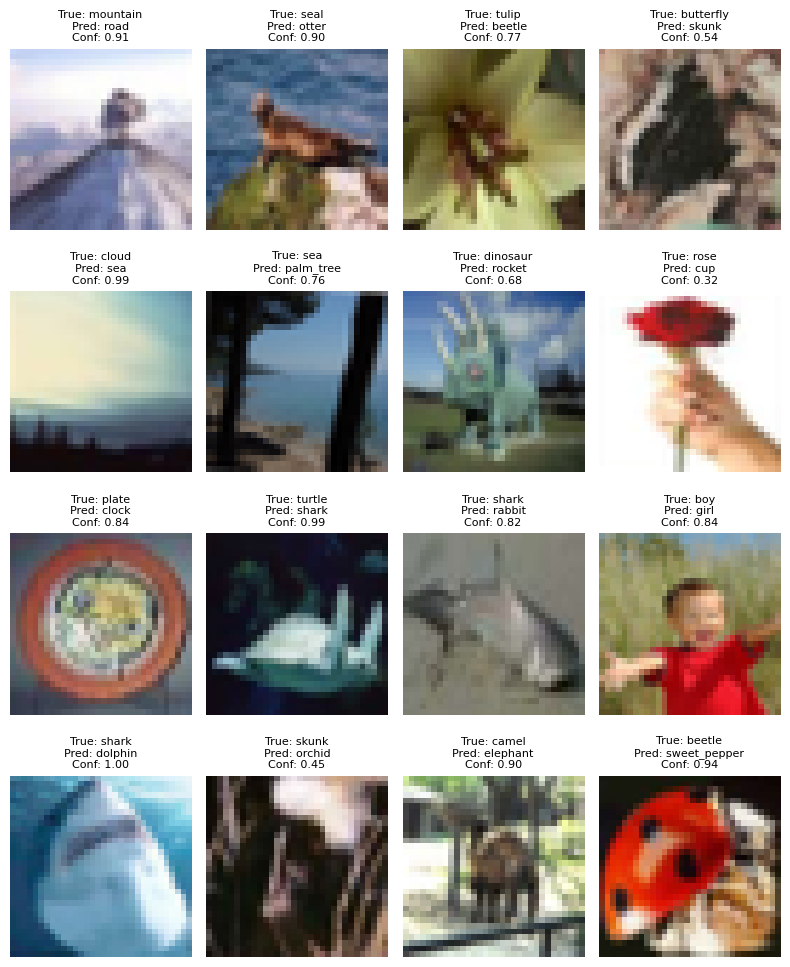

In [ ]:
class_names = train_ds.ds.classes
misclassified, worst_classes = analyze_misclassifications(model, device, test_loader, class_names, top_k=5)
show_misclassified(misclassified, class_names, n=16)